In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from tqdm import tqdm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, r2_score, pairwise_distances
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
import warnings

# ==== New Function: High-D Metrics ====
def compute_metrics_high_dim(X_data, labels, mask):
    """
    Computes NMI and Linear Decoding R2 on the original 512-D data
    (masked by the specific condition).
    """
    # Filter data based on mask
    X_subset = X_data[mask]
    y_subset = labels[mask]
    
    # If too few samples, return NaNs
    if len(X_subset) < 5:
        return 0.0, 0.0

    # --- Metric 1: NMI (Clustering Separation) ---
    n_classes = len(np.unique(y_subset))
    if n_classes < 2: 
        nmi = 0.0 # Cannot cluster if only 1 class
    else:
        kmeans = KMeans(n_clusters=n_classes, random_state=0, n_init=10)
        labels_pred = kmeans.fit_predict(X_subset)
        nmi = normalized_mutual_info_score(y_subset, labels_pred)
    
    # --- Metric 2: R2 (Linear Decodability) ---
    # Ridge Regression is more stable for high-D embeddings
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X_subset, y_subset, test_size=0.2, random_state=42
        )
        # decoder = Ridge(alpha=1.0)
        decoder = LinearRegression()
        decoder.fit(X_train, y_train)
        y_pred = decoder.predict(X_test)
        r2 = r2_score(y_test, y_pred)
    except ValueError:
        r2 = 0.0 # Handle cases with insufficient splits
        
    return nmi, r2

# ==== Warnings Configuration ====
warnings.filterwarnings("ignore", message=".*force_all_finite.*")
warnings.filterwarnings("ignore", message=".*n_jobs value 1 overridden to 1.*")
warnings.filterwarnings("ignore", message=".*Graph is not full*")
warnings.filterwarnings("ignore", message=".*get_cmap*")

N_arch = 10
n_neighbors = 200
min_dist = 1
state_id = 0

# Adjust paths as needed
X_raw_all = [f"./emb/sm_spectral_IHC3000_A{i:02d}_all_emb_penultimate_512.npy" for i in range(1, 11)]
azim_labels_all = [f"./emb/sm_spectral_IHC3000_A{i:02d}_all_azimuth.npy" for i in range(1, 11)]
elev_labels_all = [f"./emb/sm_spectral_IHC3000_A{i:02d}_all_elevation.npy" for i in range(1, 11)]
smoothed_labels_all = [f"./emb/sm_spectral_IHC3000_A{i:02d}_all_smoothed.npy" for i in range(1, 11)]

mean_dist_all = []

for m in tqdm(range(N_arch)):

    # Load Data
    X_raw = np.load(X_raw_all[m]) ## (2340, 512)
    azim_labels = np.squeeze(np.load(azim_labels_all[m])) ## (2340,)
    azim_labels = ((azim_labels + 180) % 360) - 180   ## [-180,    0] degrees
    elev_labels = np.squeeze(np.load(elev_labels_all[m])) ## [ 0, 10, 20, 30, 40, 50, 60]
    smoothed_labels = np.squeeze(np.load(smoothed_labels_all[m])) 
    
    # Filter for specific Azimuth (0 or 180)
    mask = np.isin(azim_labels, [0]) 
    indices = np.where(mask)[0]
    
    X = X_raw[indices] # High-D Data
    
    # Use elevation as the "class" for NMI/R2
    current_elevs = elev_labels[indices]
    
    # UMAP for Visualization ONLY
    umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                           n_components=2, random_state=state_id) 
    umap_results = umap_model.fit_transform(X) 
    
    umap_df = pd.DataFrame({
        "umap1": umap_results[:, 0],
        "umap2": umap_results[:, 1],
        "angle": current_elevs, # used for coloring by elevation
        "smoothed": smoothed_labels[indices],
        "elevation": current_elevs,
    })
    
    # ==== Plotting ====
    fig, ax = plt.subplots(figsize=(6, 6))
    cmap = plt.cm.get_cmap('jet')
    # Normalize angle for color mapping
    c_norm = (umap_df["angle"] - umap_df["angle"].min()) / (umap_df["angle"].max() - umap_df["angle"].min())
    colors = cmap(c_norm.values)
    
    marker_size = 50
    
    # Plot specific conditions with High-D Metrics in label
    plot_conditions = [
        (256, 'white', 'o', "sm 256"),
        (64, 'silver', 's', "sm 64"),
        (16, 'gray', 'd', "sm 16"),
        (1, 'black', 'p', "sm 1")
    ]

    for sm_val, face_c, mark, label_base in plot_conditions:
        mask_r = (umap_df["smoothed"] == sm_val)
        
        # Calculate Metrics on High-D X (using the boolean mask)
        nmi, r2 = compute_metrics_high_dim(X, current_elevs, mask_r)
        
        label_text = f"{label_base} {nmi:.2f} {r2:.2f}"
        
        ax.scatter(
            umap_df.loc[mask_r, "umap1"],
            umap_df.loc[mask_r, "umap2"],
            s=marker_size,
            facecolors=face_c,
            edgecolors=colors[mask_r],
            alpha=0.9,
            linewidths=1,
            marker=mark,
            label=label_text,
        )

    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    ax.set_aspect("equal", "box")
    ax.legend(markerscale=1, frameon=False)
    plt.tight_layout()
    plt.savefig(f"IHC3000_A{m+1:02d}_n_neighbors{n_neighbors}_min_dist{min_dist}_emb.pdf", 
                dpi=300, bbox_inches='tight')
    plt.close()
    
    # ==== Distance Quantification (High-D Cosine) ====
    
    # 1. Prepare unique smooth factors and elevations
    smooth_vals = np.sort(np.unique(umap_df["smoothed"].values))
    elev_vals   = np.unique(umap_df["elevation"].values)
    
    n_smooth = len(smooth_vals)
    n_elev   = len(elev_vals)
    
    dist_array = np.full((n_smooth, n_elev), np.nan)
    ref_smooth = 256  # Reference condition
    
    # 2. Pre-compute reference centroids in 512D
    ref_centers_hd = {} 
    
    for elev in elev_vals:
        # Boolean mask for reference rows
        mask_ref = (umap_df["smoothed"] == ref_smooth) & (umap_df["elevation"] == elev)
        
        # Select from High-D X
        pts_ref_hd = X[mask_ref] 
        
        if len(pts_ref_hd) == 0:
            continue
        ref_centers_hd[elev] = pts_ref_hd.mean(axis=0) # Mean vector (512,)
    
    # 3. Compute Cosine Distances for every (smooth, elevation)
    for i, s_val in enumerate(smooth_vals):
        for j, elev in enumerate(elev_vals):
            if elev not in ref_centers_hd:
                continue
            
            mask_s = (umap_df["smoothed"] == s_val) & (umap_df["elevation"] == elev)
            pts_s_hd = X[mask_s]
            
            if len(pts_s_hd) == 0:
                continue
                
            center_s_hd = pts_s_hd.mean(axis=0)
            center_ref_hd = ref_centers_hd[elev]
            
            # Reshape for sklearn: (1, 512)
            c1 = center_s_hd.reshape(1, -1)
            c2 = center_ref_hd.reshape(1, -1)
            
            # Cosine Distance: returns matrix, take [0,0]
            d = pairwise_distances(c1, c2, metric='euclidean')[0, 0]
            dist_array[i, j] = d
    
    # 4. Compute mean and SEM across elevations
    mean_dist = np.nanmean(dist_array, axis=1)
    mean_dist_all.append(mean_dist)
    
    sem_dist = np.zeros_like(mean_dist)
    for i in range(n_smooth):
        row = dist_array[i, :]
        valid = np.isfinite(row)
        n_valid = valid.sum()
        if n_valid > 1:
            sem_dist[i] = np.nanstd(row[valid], ddof=1) / np.sqrt(n_valid)
    
    # 5. Plot Distance Results
    fig, ax = plt.subplots(figsize=(7, 5))
    cmap_elev = plt.cm.get_cmap('jet', len(elev_vals))
    
    for j, elev in enumerate(elev_vals):
        ax.scatter(
            smooth_vals,
            dist_array[:, j],
            s=40,
            color=cmap_elev(j),
            alpha=0.8,
            label=f"elev {int(elev)}°"
        )
    
    ax.errorbar(
        smooth_vals,
        mean_dist,
        yerr=sem_dist,
        fmt="-o",
        linewidth=2,
        color='black',
        capsize=0,
        markersize=2,
        label="mean ± SEM",
    )
    
    ax.set_xscale("log", base=2)
    ax.set_xticks(smooth_vals)
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.set_xlabel("Number of cosines")
    ax.invert_xaxis()
    ax.set_ylabel("Cosine Distance to smoothed=256 (High-D)")
    ax.set_title("Shift in Neural Manifold (High-D)")
    ax.legend(frameon=False)
    
    plt.tight_layout()
    # plt.savefig(f"IHC3000_A{m+1:02d}_n_neighbors{n_neighbors}_min_dist{min_dist}_quantify.pdf", 
    #             dpi=300, bbox_inches='tight')
    plt.close()

100%|███████████████████████████████████████████| 10/10 [00:53<00:00,  5.38s/it]


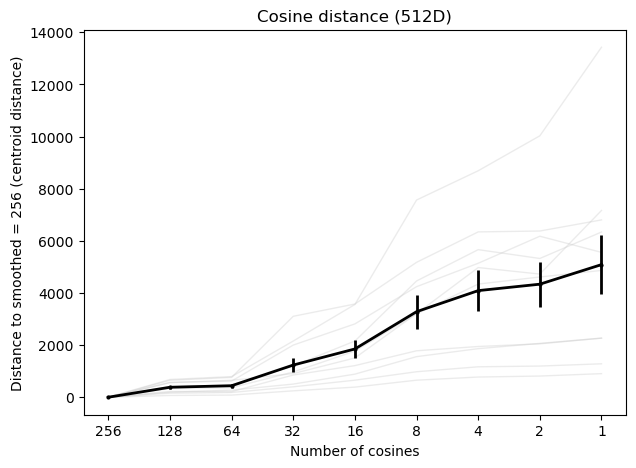

In [3]:
arch_mean=np.nanmean(mean_dist_all, axis=0)
arch_std=np.std(mean_dist_all, axis=0)
arch_sem=arch_std/np.sqrt(N_arch)
fig, ax = plt.subplots(figsize=(7, 5))
for i in range(N_arch):
    ax.plot(
        smooth_vals,
        mean_dist_all[i],
        marker="o",
        linewidth=1,
        markersize=0,
        alpha=0.3,
        color="silver",    # orange
    )
ax.errorbar(
        smooth_vals,
        arch_mean,
        yerr=arch_sem,
        fmt="-o",
        linewidth=2,
        color='black',
        capsize=0,
        markersize=2,
        label="mean ± SEM",
    )
ax.set_xscale("log", base=2)  # optional; remove if you want linear x-axis
ax.set_xticks(smooth_vals)
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # show tick labels as 1,2,4,...
ax.set_xlabel("Number of cosines")
ax.invert_xaxis()
ax.set_ylabel("Distance to smoothed = 256 (centroid distance)")
ax.set_title("Cosine distance (512D)")
plt.savefig("IHC3000_Arch_All_Euclidean_Wider.pdf", dpi=300, bbox_inches='tight')
# ax.legend(frameon=False)